## Test - BRemNet segmented

In [1]:
import cv2
import numpy as np
from PIL import Image

%pylab inline
import matplotlib.pyplot as plt

import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
mask = Image.open("out_bremnet/bremnet_segm.png")
mask = mask.convert('RGBA')
original_size = mask.size

print(original_size)

(1080, 1920)


#### background transparent

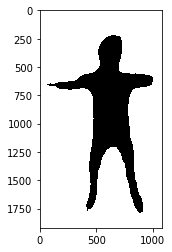

In [3]:
background = (255,255,255,0)
transparent = (0,0,0,0)
black = (0,0,0,255)

mask_transparentbg = []

for color in mask.getdata():
    #print(color)
    if color == background:
        mask_transparentbg.append(transparent)
    else:
        mask_transparentbg.append(black)

new_mask = Image.new(mask.mode, mask.size)
new_mask.putdata(mask_transparentbg)

#resize (512, 424)
#new_mask.thumbnail((512,512), Image.ANTIALIAS)
    
new_mask.save('out_bremnet/bremnetsegm_transparentbg.png')
plt.imshow(np.asarray(new_mask))

In [4]:
image = cv2.imread('out_bremnet/bremnetsegm_transparentbg.png', cv2.IMREAD_UNCHANGED)
image

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

### image info

In [5]:
alpha = image[:, :, 3]
print("alpha ", alpha)

cdata = image[:, :, :3]
cdata = cv2.cvtColor(cdata, cv2.COLOR_BGR2GRAY)
print("cdata ", cdata)

alpha  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
cdata  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [6]:
margin_1 = np.sum(alpha, axis=0)
margin_2 = np.sum(alpha, axis=1)

print("margin_1 shape ", margin_1.shape)
print("margin_1 ", margin_1)
print("margin_2 ", margin_2)

margin_1 shape  (1080,)
margin_1  [0 0 0 ... 0 0 0]
margin_2  [0 0 0 ... 0 0 0]


In [7]:
top = np.nonzero(margin_2)[0][0]
bottom = np.nonzero(margin_2)[0][-1]
left = np.nonzero(margin_1)[0][0]
right = np.nonzero(margin_1)[0][-1]

print("top ", top)
print("bottom", bottom)
print("left", left)
print("right", right)

top  224
bottom 1790
left 63
right 991


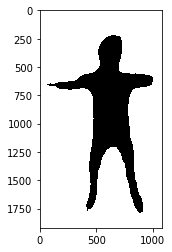

In [8]:
plt.imshow(image)

In [9]:
width = right - left
height = bottom - top

print("width ", width)
print("height ", height)

width  928
height  1566


In [10]:
alpha = alpha[top:bottom, left:right]
cdata = cdata[top:bottom, left:right]

print("alpha ", alpha)
print("cdata ", cdata)

alpha  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
cdata  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### scaler

In [11]:
target_window = 190
margin = 30

if height > width:
	scaler = (target_window, int(float(width * height)/(target_window*2)))
else:
	scaler = (int(float(width * height)/target_window), target_window)
    
print(scaler)

(190, 3824)


target_window = 190
margin = 30
#scaler = (target_window, target_window)

if height > width:
	scaler = (target_window, int(float(target_window * width)/height))
else:
	scaler = (int(float(target_window * height)/width), target_window)
    
print(scaler)

In [12]:
depth_image = cv2.resize(cdata, scaler)
depth_mask = cv2.resize(alpha, scaler) == 255

average_depth = np.mean(depth_image[depth_mask])

depth_image[depth_mask] = np.uint8(np.int64(depth_image[depth_mask])) + np.int64(55 - average_depth)
depth_image[~depth_mask] = 255
depth_image = depth_image.astype(float)/255

print("depth_image shape ", depth_image.shape)
print("depth_mask shape ", depth_mask.shape)

depth_image shape  (3824, 190)
depth_mask shape  (3824, 190)


In [13]:
height, width = depth_image.shape[0], depth_image.shape[1]

print("width ", width)
print("height ", height)

width  190
height  3824


In [14]:
final_depth_image = np.ones((target_window + 2 * margin, target_window + 2 * margin), dtype=float)
final_depth_mask = np.zeros((target_window + 2 * margin, target_window + 2 * margin), dtype=bool)

print("final_depth_image shape ", final_depth_image.shape)
print("final_depth_mask shape ", final_depth_mask.shape)

final_depth_image shape  (250, 250)
final_depth_mask shape  (250, 250)


In [15]:
loc_x = int(np.floor((target_window + 2 * margin - width)/2) + 1)
loc_y = int(np.floor((target_window + 2 * margin - height)/2) + 1)

print("loc_x ", loc_x)
print("loc_y ", loc_y)

loc_x  31
loc_y  -1786


In [16]:
final_depth_image[loc_y: (loc_y + height), loc_x: (loc_x + width)] = depth_image
final_depth_mask[loc_y: (loc_y + height) , loc_x: (loc_x + width)] = depth_mask * 255

final_depth_image = np.float32(final_depth_image)

print("final_depth_image shape ", final_depth_image.shape)
final_depth_image

ValueError: could not broadcast input array from shape (3824,190) into shape (250,190)

### model

In [ ]:
net = cv2.dnn.readNetFromCaffe("caffe_models/deploy.prototxt", "caffe_models/hardpose_69k.caffemodel")
blob = cv2.dnn.blobFromImage(final_depth_image, 1, (250, 250), (), True, False)
net.setInput(blob)
out = net.forward()

out

In [ ]:
classes =  np.argmax(out, axis=1)
classes = np.reshape(classes, (250, 250))
classes[~final_depth_mask] = 0

In [ ]:
x,y = np.nonzero(classes)

classes = np.uint8(classes)
classes = classes * 5

print(np.unique(classes))
classes

In [ ]:
mask_seg = cv2.applyColorMap(classes, cv2.COLORMAP_HSV)

cv2.imwrite("out_bremnet/bremnetsegm_seg0.png", mask_seg)
plt.imshow(mask_seg)

In [ ]:
print(np.unique(mask_seg))
mask_seg

In [ ]:
image_seg = Image.open("out_bremnet/bremnetsegm_seg0.png")

red_bg = (255,0,0)
white = (255,255,255)

new_white = []

for color in image_seg.getdata():
    #print(color)
    if color == red_bg:
        new_white.append(white)
    else:
        new_white.append(color)

new_image = Image.new(image_seg.mode, image_seg.size)
new_image.putdata(new_white)
    
new_image.save('out_bremnet/bremnetsegm_seg1.png')
plt.imshow(np.asarray(new_image))

In [ ]:
#seg_resize = new_image.resize(original_size)
#seg_resize.save('out_bremnet/bremnetsegm_segmented.png')

In [ ]:
seg_resize = new_image.resize((1080, 1080))
seg_resize.save('out_bremnet/bremnetsegm_segmented_1080.png')

## measure

In [ ]:
image.shape

In [ ]:
# ROI:
m_mask = cv2.imread(os.path.abspath("out_bremnet/bremnetsegm_transparentbg.png"))
m_gray = cv2.cvtColor(m_mask, cv2.COLOR_RGB2GRAY)
m_thresh, m_bw = cv2.threshold(m_gray, 128, 255, 0)
m_inv = cv2.bitwise_not(m_bw)
    
# Get rectangle
contours, hierarchy = cv2.findContours(m_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
maxarea = 0
cnt = None

for h, tcnt in enumerate(contours): 
    area = cv2.contourArea(tcnt)
    if area > maxarea:
        maxarea = area
        cnt = tcnt

    (x,y,w,h)=(0,0,0,0)
    if cnt.any() != None:
        x,y,w,h = cv2.boundingRect(cnt)
            
crop_mask = m_mask[y:y+h, x:x+w]
plt.imshow(crop_mask)

In [ ]:
crop_mask.shape